In [1]:
!pip install imutils
!pip install pytesseract

## This code will run openCv to identify the licence plate of a car and then run different algorithm to identify the licence plate area from the car and crop it, another library pytesseract will then conver the image using OCR into text

### preprocess_image 
#### This function load an image from a file path, resize it to a specified width while maintaining the aspect ratio, and obtain the preprocessed image in the form of a NumPy array. Once the preprocessed image is created, this will help in  applying various computer vision or image processing techniques to the image.

### apply_bilateral_filter
####  The apply_bilateral_filter function provides a way to reduce noise and smoothen a grayscale image while preserving important edges. The bilateral filter is a versatile image processing technique that can be useful in various computer vision and image analysis tasks, especially when dealing with noisy images while preserving edges and fine details.

### detect_edges
#### This function provides a convenient way to perform edge detection on a grayscale image using the Canny algorithm. The output is a binary image that highlights the detected edges, which can be useful for various computer vision tasks, including object detection, feature extraction, and image segmentation.

### find_and_draw_contours
#### This function is a multi-step process that identifies the license plate region in an image using contour detection, draws a blue contour around it on both the original image and a separate image, and saves the extracted license plate region as a cropped image.

### extract_text_from_image
#### the image that is cropped will be passed to this method to extract the text using ocr, the library that will be used is pytesseract, it is pythong wrapper on top of tessaract which should be installed seperately

Number plate is: Y26 MAY 

Image - 1


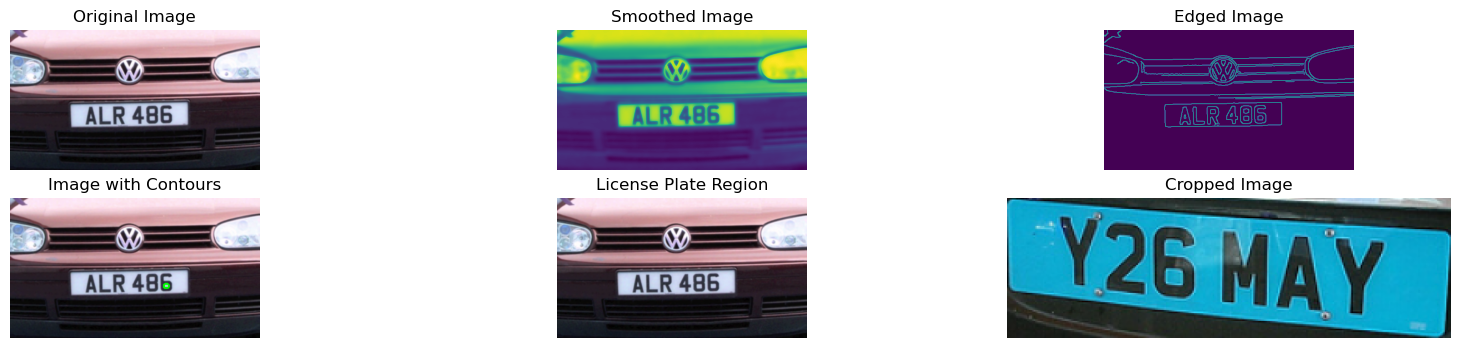

Number plate is: DL8CX 4850 

Image - 2


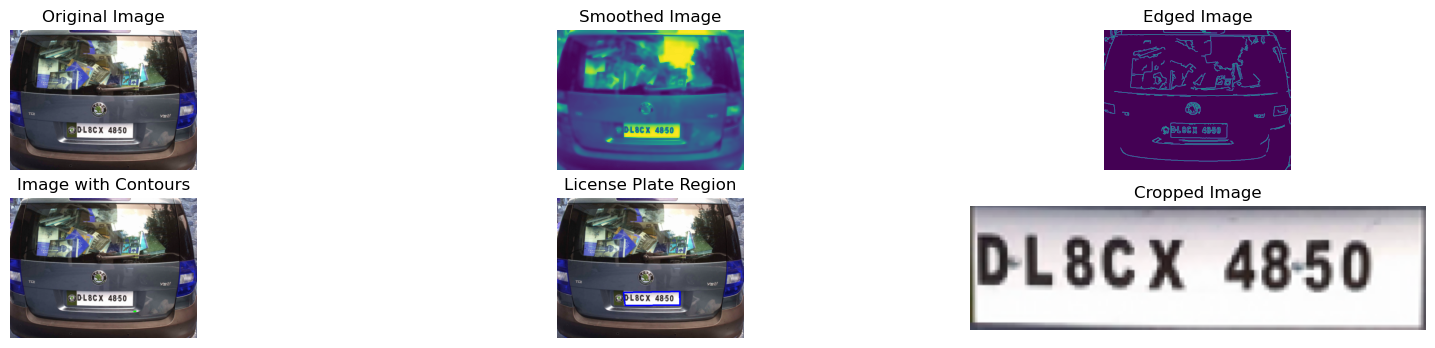

Number plate is: DL8CX 4850 

Image - 3


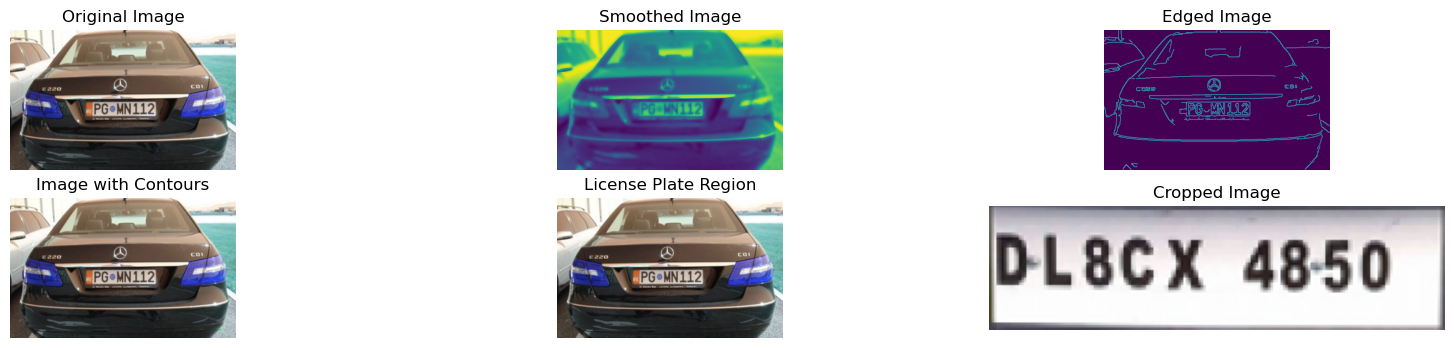

Number plate is: -DZI7-YXR 

Image - 4


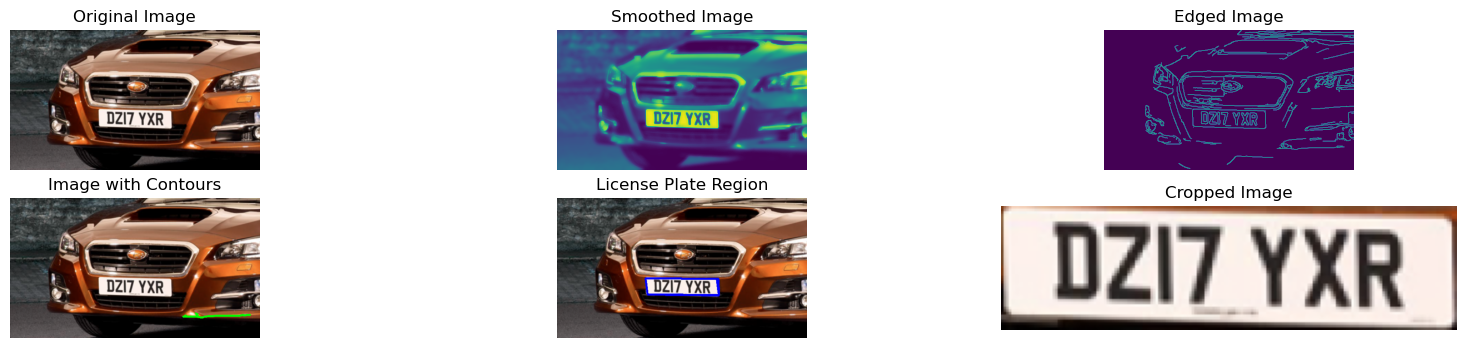

Number plate is: Y26 MAY 

Image - 5


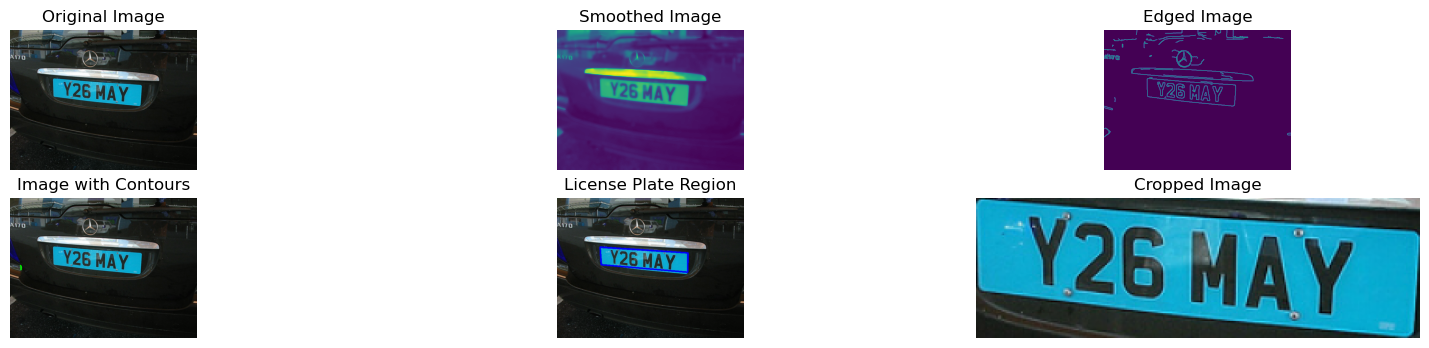

In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import pytesseract
import re

def preprocess_image(image_path, resize_width=600):
    # Load the image and resize it to the specified width
    image = cv2.imread(image_path)
    image = imutils.resize(image, width=resize_width)    
    return image

def apply_bilateral_filter(image):
    # first convert the color image to gray and then use the bilateral filter
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply bilateral filter to smoothen the grayscale image
    smoothed_image = cv2.bilateralFilter(gray_image, 15, 80, 80)
    return smoothed_image

def detect_edges(gray_image):
    # Detect edges in the grayscale image using Canny edge detection
    edged_image = cv2.Canny(gray_image, 50, 100)
    return edged_image

def find_and_draw_contours(image, edged_image, min_contour_area=1000):
    # Find contours in the edged image
    cnts, _ = cv2.findContours(edged_image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original image for drawing contours
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, cnts, 3, (0, 255, 0), 3)

    # Loop through the contours to identify and draw the license plate region
    screenCnt = None
    image_with_license_plate = image.copy()
    for c in cnts:
        perimeter = cv2.arcLength(c, True) #send true as we want to identify closed contour and not a curve
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        if len(approx) == 4 and cv2.contourArea(c) > min_contour_area:
            screenCnt = approx
            cv2.drawContours(image_with_license_plate, [screenCnt], -1, (0, 0, 255), 3)
            x, y, w, h = cv2.boundingRect(c)
            new_img = image[y:y + h, x:x + w]
            cv2.imwrite('./cropped_lic_plate.png', new_img)
    
    cropped_img = cv2.imread('./cropped_lic_plate.png')                 
    return image_with_contours, image_with_license_plate, cropped_img

def display_images(images, titles, num_rows=1, num_cols=3, figsize=(12, 6)):
    # Display multiple images with corresponding titles in a grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
            
    for i, ax in enumerate(axes.flat):           
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(titles[i])
    plt.show()  
    
def extract_text_from_image(image):
    #use pytesseract to read the image and convert into text
    custom_config =  r'--oem 3 --psm 8'  # settings tried out to read character more clearly, 7/8 psm is for licence plate
    plate = pytesseract.image_to_string(cropped_lp_img, lang='eng', config=custom_config)

    #run regex to remove some character that came up due to image boundry
    pattern = r'[_|)]'
    truncated_plate = re.sub(pattern, '', plate)

    print("Number plate is:", truncated_plate) 

    
if __name__ == "__main__":
    i=1
    image_paths = ['./images/Cars14.png','./images/Cars13.png','./images/Cars1.png','./images/cars27.png','./images/cars5.png']    
    for path in image_paths:
        image = preprocess_image(path)

        smoothed_image = apply_bilateral_filter(image)

        edged_image = detect_edges(smoothed_image)
        
        image_with_contours, image_with_license_plate, cropped_lp_img = find_and_draw_contours(image, edged_image)
        
        #extract the text
        extract_text_from_image(cropped_lp_img)
        
        # Display the results
        images = [image, smoothed_image, edged_image, image_with_contours, image_with_license_plate,cropped_lp_img]
        titles = ["Original Image", "Smoothed Image", "Edged Image", "Image with Contours", "License Plate Region","Cropped Image"]
        print(f'Image - {i}') 
        display_images(images, titles, num_rows=2, num_cols=3, figsize=(20, 4))
        i += 1
